# Answers

You can edit this Jupyter notebook to include your answers and run any code that generates those answers or produces plots.  You can add additional cells for code or markdown as needed.

In [69]:
import numpy as np
import scipy as sp
import scipy.linalg as la
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft

## Problem 0
The Fourier transform, denoted by $\mathcal F$, can be used to solve differential equations. One can show that the Fourier transform of a derivative satisfies
$$\mathcal F\left[f'\right] = i \omega \mathcal F\left[f\right]$$
where the $\omega$ is the variable in the transformed space (i.e. frequency).
The above equation may differ by a constant depending on which convention you're using for the Fourier transform. 

To solve $u$ to the ODE
$u''(x) = g(x)$
on the domain $[0,2\pi]$ with periodic boundary constraints $u(0) = u(2\pi)$ and $g(0) = g(2\pi)$, we observe that
$$- \omega^2 \mathcal F[u]= \mathcal F[g].$$
Therefore 
$$u(x) = \mathcal F^{-1}\left[-\frac{1}{\omega^2}\mathcal F[g](\omega)\right](x).$$


This works great in theory, but often the right-hand side of the above equation is hard to compute in practice.

Instead, we discretize $g(x)$ on $[0,2\pi]$ by evaluating it at $N$ equally spaced points. This gives us a vector $\mathbf g\in\mathbb R^N$. Our goal is to find a vector $\mathbf u\in\mathbb R^N$ that is approximately equal to the evaluation of $u(x)$.
The discrete Fourier transform of $\mathbf g$ is approximately the same as the discretization of $\mathcal F[g]$, and similarly for $u$.

Because $\mathcal F$ is a linear transformation, the discrete Fourier transform of a function can be computed via multiplication of $\mathbf f$ by the appropriate matrix, which takes $O(N^2)$ time. However, in 1965, Cooley and Tukey developed [an algorithm](https://www.ams.org/journals/mcom/1965-19-090/S0025-5718-1965-0178586-1/) for computing the discrete Fourier transform in $O(N \log N)$ time. (The first part of [this webpage](https://www.cmlab.csie.ntu.edu.tw/cml/dsp/training/coding/transform/fft.html) gives a descent explanation of how this algorithm works.) Their fast Fourier transform and its inverse are implemented in `scipy.fft` as `fft` and `ifft`.
$\DeclareMathOperator{\fft}{fft}$

$\DeclareMathOperator{\ifft}{ifft}$
Putting this all together, we get that 
$$\mathbf u \approx \ifft(\;-\frac{1}{\omega^2}\;*\;\fft(\mathbf g)\;).$$

### Part A
Solve $u''(x) = -\sin(x)$ for $u$ with periodic boundary conditions using the Fast Fourier transform. Use $N=50$. Solve the equation analytically as well with $u(0) = u(2\pi) = 0$. Plot the solution you found with the FFT as well as the analytic solution with a legend and title. What is the maximum modulus of error on the evaluation points?  Because the Fourier transform is defined for complex variables, by using the FFT we introduce error by adding a small imaginary part to the solution. What is the largest imaginary value in your solution?

Hint: Because scipy rearranges which $\omega$ corresponds to which entry in the vector, $\fft(\mathbf g)$, you will need to be careful in how you divide by $\omega^2$. For $N$ even, 
- Entries $0$ to $N/2 - 1$ correspond to $\omega = 0,\ldots,N/2 - 1$
- Entries $N/2$ to $N-1$ correspond to $\omega = -N/2, \ldots, -1$.

Also, do not divide by $\omega^2$ for the term corresponding to $\omega = 0$.

the largest error is 0.06027924218428727
 
the largest imag value is 1.4210854715202004e-16


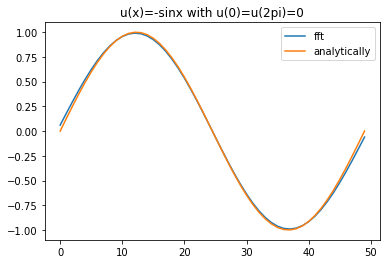

In [70]:
# Analytically, u(x) = sin(x)+c is a solution. Use the inital conditions
# 0=u(0)=c implies c=0 and therefore u(x)=sin(x) is the unique solution
# w.r.t. the ics.

# use fft and ifft
grid = np.linspace(0, 2*np.pi, 50)
g = -np.sin(grid)
omi1 = np.arange(25)  # grid
omi2 = np.arange(-25, 0, 1)
omiga = np.concatenate([omi1, omi2])
omiga[0] = 1

fhat = fft(g)
u = ifft(-fhat/(omiga)**2)
print('the largest error is {}'.format(la.norm(-g-u, np.inf)))
print(' ')
print('the largest imag value is {}'.format(la.norm(np.imag(u), np.inf)))

plt.plot(np.real(u), label='fft')
plt.plot(-g, label='analytically') # u=-g
plt.title('u''(x)=-sinx with u(0)=u(2pi)=0')
plt.legend()

### Part B
Solve $u''(x) = \exp(-(x-\pi)^2)$ for $u$ with periodic boundary conditions using the Fast Fourier transform. Use $N=50$. Plot the solution.

the largest error is 0.2252009086693455
 
the largest imag value is 9.5761287209702e-17


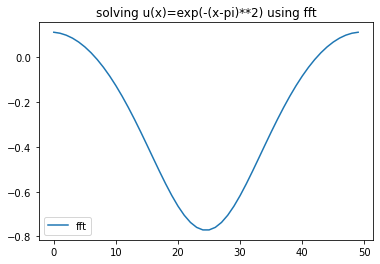

In [71]:
# use fft and ifft
grid = np.linspace(0, 2*np.pi, 50)
g = np.exp(-(grid-np.pi)**2)
omi1 = np.arange(25)
omi2 = np.arange(-25, 0, 1)
omiga = np.concatenate([omi1, omi2])
omiga[0] = 1

fhat = fft(g)
u = ifft(-fhat/(omiga)**2)
print('the largest error is {}'.format(la.norm(-g-u, np.inf)))
print(' ')
print('the largest imag value is {}'.format(la.norm(np.imag(u), np.inf)))

plt.plot(np.real(u), label='fft')
plt.title('solving u''(x)=exp(-(x-pi)**2) using fft')
plt.legend()

## Problem 1

Finding the global or local minimizer for a specific function is an ubiquitous task in applied sciences. Given a potential function $V(x)$,
\begin{equation}
V(x) = (x^2-1)^2 + 0.1*x,
\end{equation}
which is usually referred as the "double-well" potential. As locally convex function, it has two minimizers located in -1 and 1. There are multiple ways to find the minimizers of the function

### Part A
For a convex function or locally convex function, simple [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) with proper initial guess is a good candidate of minimization algorithm. Assume one starts with initial guess $x_0$, the gradient descent algorithm seeks a sequence of points $x_1,x_2,\cdots,x_n$ such that $x_{n}=x_{n-1} - \alpha_{n-1}\nabla V(x_{n-1})$, where $\alpha_{n-1}$ is the step size and $\nabla (x_{n-1})$ is the gradient of the given potential function at the current point. This procedure can also be considered as the **gradient flow** dynamics in the continuous sense:
\begin{equation}
\frac{dx_t}{dt} = -\nabla V(x_t).
\end{equation}
Try to find the minimizers of the double-well potential function by simulating the gradient flow ODE dynamics. Note that different initializations may lead to different minimizers (falling into different potential wells). You can use Scipy's ODE solver [`solve_ipv`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) with your preferred method or the Forward Euler solver you implemented in HW4.

### Part B
Another approach is the Newton's method we have covered in the class. We can also find the minimizers of the function by computing the critical points of its gradient. Write a function to use Newton's method to recover both local minimizers of $V$.

In [72]:
# Part A
from scipy.integrate import solve_ivp

def gradientflow(x0):
    """
    Find global and local minimizer using gradiend flow
    """
    f = lambda t, x : -(4*x**3-4*x+0.1)  # gradient(V)

    tol = 1e-3
    i=10
    t_span = (0, 10)
    t_eval = np.linspace(0,10, 20)
    sol = solve_ivp(f, t_span, x0, t_eval=t_eval)
    while abs(sol.y[0, -1]-sol.y[0, -2])>=tol:  # stopping criteria
        t_span = (0, 10*i)
        t_eval = np.linspace(0,10*i, 20*i)
        sol = solve_ivp(f, t_span, x0, t_eval=t_eval)
    return sol.y[0, -1]

Minimizer1 = gradientflow(np.array([5]))
Minimizer2 = gradientflow(np.array([-5]))
print('two minimizer of the potential function is {} and {}'.format(Minimizer1, Minimizer2))


two minimizer of the potential function is 0.9877082918718638 and -1.0123939655636423


In [73]:
# Part B
def Newton(x0, tol=1e-8):
    """
    find a point x so that f(x) is close to 0,
    measured by abs(f(x)) < tol

    Use Newton's method starting at point x0
    """
    fder = lambda x : 4*x**3-4*x+0.1  # first derivative of V
    fderder = lambda x : 12*x**2-4   # second derivative of V
    
    while True:
        x1=x0 - fder(x0) / fderder(x0)  # Newtons method
        if abs(fder(x1)) < tol:
            break
        x0=x1
    return x1

Minimizer1 = Newton(5)
Minimizer2 = Newton(-5)
print('two minimizer of the potential function is {} and {}'.format(Minimizer1, Minimizer2))


two minimizer of the potential function is 0.9872574766623533 and -1.012273131960323


## Problem 2

### Part A
Consider the following stochastic differential equation
\begin{equation}
dX_t = -\nabla V(X_t) dt + \sqrt{2\beta^{-1}} dW_t
\end{equation}
where $X_t\in\mathbb{R}$ is the state of the system, $W_t$ is a one-dimensional Wiener process and $\beta$ is a constant. This process is usually referred as the overdamped Langevin process. 

We can simulate the overdamped Langevin process by discrete-time method. One of the simplest is the Euler-Maruyama ethod with fixed time step. Please read [Euler-Maruyama method](https://en.wikipedia.org/wiki/Euler%E2%80%93Maruyama_method) for details. 

Implement the Euler-Maruyama simulator for $\beta=0.5$ and draw an ensemble of $10^4$ independent samples from the standard normal distribution $\mathcal{N}(0,1)$ as our initial samples. Simulate the sample path for each of the samples. Visualize the sample distribution using histograms for $t=0.02,0.06,0.1,0.5$. What do you observe and how do you explain your findings?

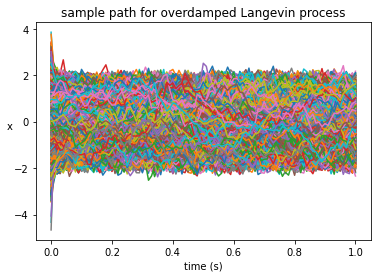

In [2]:
num_sims = 10000  # Display 10^4

t_init = 0
t_end  = 1
N      = 100  # Compute 10000 grid points
dt     = float(t_end - t_init) / N
mu, sigma = 0, 1
s = np.random.normal(mu, sigma, 10000)  # random sample 
c_beta = 0.5


def deltaV(x, t):
    """Implement the overdamped Langevin gradient(V)."""
    return 4*x**3 - 4*x + 0.1

def betacon(x, t):
    """Implement the the overdamped Langevin gradient(V) beta"""  
    return np.sqrt(2/c_beta)

def dW(delta_t):
    """Sample a random number at each call."""
    return np.random.normal(loc=0.0, scale=np.sqrt(delta_t))

ts = np.arange(t_init, t_end + dt, dt)

hist1 = np.zeros(10000)
hist2 = np.zeros(10000)
hist3 = np.zeros(10000)
hist4 = np.zeros(10000)
for j in range(num_sims):
    xs = np.zeros(N + 1)
    xs[0] = s[j]
    for i in range(1, ts.size):
        t = t_init + (i - 1) * dt
        x = xs[i - 1]
        xs[i] = x - deltaV(x, t) * dt + betacon(x, t) * dW(dt)
    hist1[j] = xs[2]  # use for histogram at t=0.02
    hist2[j] = xs[6]  # use for histogram at t=0.06
    hist3[j] = xs[10]  # use for histogram at t=0.1
    hist4[j] = xs[50]  # use for histogram at t=0.5
    plt.plot(ts, xs)

plt.xlabel("time (s)")
plt.title('sample path for overdamped Langevin process')
h = plt.ylabel("x")
h.set_rotation(0)
plt.show()

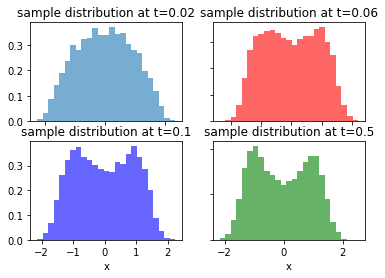

In [10]:


fig, axs = plt.subplots(2, 2)
axs[0, 0].hist(hist1, bins=25, density=True, alpha=0.6)
axs[0, 0].set_title('sample distribution at t=0.02')
axs[0, 1].hist(hist2, bins=25, density=True, alpha=0.6, color='r')
axs[0, 1].set_title('sample distribution at t=0.06')
axs[1, 0].hist(hist3, bins=25, density=True, alpha=0.6, color='b')
axs[1, 0].set_title('sample distribution at t=0.1')
axs[1, 1].hist(hist4, bins=25, density=True, alpha=0.6, color='g')
axs[1, 1].set_title('sample distribution at t=0.5')

for ax in axs.flat:
    ax.set(xlabel='x')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [ ]:
# comments: when t is small, the sample distribution is approximately
# normal distribution. When t increases, the sample distribution is
# similar to a multimodal distribution.

### Part B
The Fokker-Planck equation characterizes the evolution of the distribution of the samples. For the overdamped Langevin process discussed above, the corresponding Fokker-Planck equation is given by 
\begin{equation}
\frac{\partial p}{\partial t} = \nabla \cdot (\nabla Vp) + \frac{1}{\beta} \Delta p.
\end{equation}
Show the invariant distribution of the system is given by the Boltzmann-Gibbs distribution
\begin{equation}
p(x) \propto \exp{(-\beta V(x))}.
\end{equation}

In [ ]:
# For an invariant distribution, dp/dt=0. If p(x) = c*exp(-beta*V(x)), for
# some constant c. Then dp/dx = -(dv/dx)*beta*exp(-beta*V(x)) and
# d^2p/dx^2 = (dv/dx)^2*beta^2*exp(-beta*V(x))-(d^2v/dx^2)*beta*exp(-beta*V(x))

# Then eqn (1): (d^2p/dx^2)/beta = (dv/dx)^2*beta*exp(-beta*V(x))-(d^2v/dx^2)*exp(-beta*V(x))
# and  eqn (2): d(dV/dx*p)/dx = -(dv/dx)^2*beta*exp(-beta*V(x))+(d^2v/dx^2)*exp(-beta*V(x))
# the Fokker-Planck eqn = eqn(1) + eqn (2) = 0

### Part C
Solve the 1-dimensional Fokker-Planck PDE for the double-well potential $V$ and $\beta$ on domain $[-3,3]$ using two methods: (1) explicit finite difference scheme and (2) spectral method. More details about the spectral method can be found in [spectral method](https://en.wikipedia.org/wiki/Spectral_method). We can use the standard normal distribution as the initial condition for the PDE: $p(x,0)=\frac{1}{\sqrt{2\pi}} \exp(-\frac{x^2}{2})$ and zero boundary condition $p(-3,t)=p(3,t)=0$.

Please implement PDE solvers for numerical solution of Fokker-Planck equation using both methods. The grid size for the spatial dimension is fixed to be $\Delta x=0.05$. Note that $\Delta t$ should be sufficiently small to ensure numerical stability in explicit schemes. 

Show the time evolution of the distribution by plotting solutions $p(\cdot,t)$ for $t=0.02,0.06,0.1,0.5$. Compare the solution $p(x,t)$, the Boltzmann-Gibbs distribution and the histograms you obtained from the samples. What do you find?

Hint: For finite difference method, constructing a **sparse** finite difference matrix $M$ can greatly reduce the computational complexity. After each update, normalize the solution $p(x,t)$ to ensure numerically $\int_{-3}^{3}p(x,t)dx=1$.

In [74]:
# finite difference method
def fd(dx, tend):
    """
    perform finite difference method using for loop from t0 to tend
    In each time step t_{i+1}, use the u_i from previous time step
    to find u_{i+1}
    The finite difference scheme is (assume v=(x^2-1)^2+0.1x and beta=0.5)
    u_{j}^{t+1} = (1+ap_j-bp_j-2C)u_j^t + Cu_{j-1}^t + (bp_j+C)u_{j+1}^t,
    where ap = dt*(12x^2-4), bp = dt/dx*(4x^3-4x+0.1) and C=dt/(beta*dx^2)
    """
    Nt = 5000  # number of grids for t
    beta = 0.5
    dt = tend/Nt
    N = int(6/dx)
    x = np.linspace(-3,3,N)
    
    u0 = 1/np.sqrt(2*np.pi)*np.exp(-0.5*x**2)  # initial condition
    utemp = np.zeros(N)
    ap = dt*(12*x**2-4)
    bp = (4*x**3-4*x+0.1)*dt/dx
    C = dt/(beta*dx**2)
    
    for i in range(Nt):
        for j in range(0,N-2):
            utemp[j+1]=C*u0[j]+(1+ap[j+1]-bp[j+1]-2*C)*u0[j+1]+(bp[j+1]+C)*u0[j+2]
        tempint = np.sum(utemp)*dx  # use trapezoid method to approximate int_p dx
        u0 = utemp/tempint  # normalization
    return u0

In [58]:
# spectral method
def spectral(dx, tend):
    """
    Implement the pseudospectral method for nonlinear pde.
    the pde eqn is u_t = a(x)u + b(x)u_x + 1/beta*u_xx, where
    a(x)=V'', b(x)=V', V=(x^2-1)^2+0.1*x and beta=0.5.
    Let u(x) = sum_{n=-N/2}^{N/2} u^{hat}_n exp(epsilon*x), where
    epsilon = 2*pi*i/L. Then u_x = sum_{n=-N/2}^{N/2} u^{hat}_n epsilon*exp(epsilon*x)
    and u_x = sum_{n=-N/2}^{N/2} u^{hat}_n epsilon^2*exp(epsilon*x).
    Also, u(x) =  F^-1(F(u)). Then du_i/dt = au + b*ifft(epsilon*fft(u)) + 1/beta*ifft(epsilon^2*fft(u)).
    Use odeint to solve the ode.
    """
    L = 6
    N = int(L/dx)
    x = np.linspace(-L/2,L/2,N)
    t = np.linspace(0, tend, 100)
    a = 12*x**2-4  # V''
    b = 4*x**3-4*x+0.1 # V'
    v = (x**2-1)**2+0.1*x
    beta = 1/2
    u0 = 1/np.sqrt(2*np.pi)*np.exp(-0.5*x**2)
    
    def rhs(u, t):
        """
        return au + b*ifft(epsilon*fft(u)) + 1/beta*ifft(epsilon^2*fft(u))
        """
        N = len(u)
        n = np.arange(N)
        n[int(N/2):]-=N
        
        return a*u+(b*ifft(2*np.pi*1j*n/L*fft(u)).real-1/beta*ifft((2*np.pi*n/L)**2*fft(u)).real)
    
    u = odeint(rhs, u0, t)
    tempint = np.sum(u)*dx  # use trapezoid method to approximate int_p dx
    u = u/tempint  # normalization
    
    return u, x   

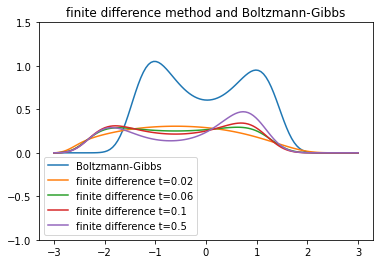

In [75]:
# implement
dx = 0.05
t = np.array([0.02, 0.06, 0.1, 0.5])
beta = 0.5
N = int(6/dx)
x = np.linspace(-3,3,N)

u1 = fd(dx, t[0])  # call the finite difference func
u2 = fd(dx, t[1])
u3 = fd(dx, t[2])
u4 = fd(dx, t[3])


# u, x = spectral(dx, t)
v = (x**2-1)**2+0.1*x
BG = np.exp(-beta*v)
# plt.plot(x,u[-1,:], label='spectral')
plt.plot(x, BG, label='Boltzmann-Gibbs')
plt.plot(x, u1, label='finite difference t=0.02')
plt.plot(x, u2, label='finite difference t=0.06')
plt.plot(x, u3, label='finite difference t=0.1')
plt.plot(x, u4, label='finite difference t=0.5')
plt.title('finite difference method and Boltzmann-Gibbs')
plt.ylim(-1,1.5)
plt.legend()

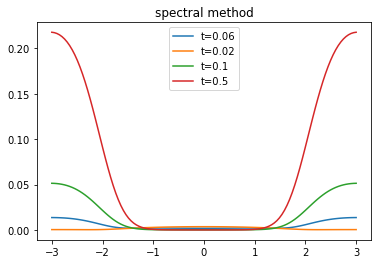

In [59]:
from scipy.integrate import odeint
dx = 0.05
t = np.array([0.02, 0.06, 0.1, 0.5])
beta = 0.5
N = int(6/dx)
x = np.linspace(-3,3,N)

u1, x = spectral(dx, t[0])  # call spectral method func
u2, x = spectral(dx, t[1])
u3, x = spectral(dx, t[2])
u4, x = spectral(dx, t[3])

plt.plot(x,u2[-1,:], label='t=0.06')
plt.plot(x,u1[-1,:], label='t=0.02')
plt.plot(x,u3[-1,:], label='t=0.1')
plt.plot(x,u4[-1,:], label='t=0.5')
plt.title('spectral method')
plt.legend()

In [ ]:
# comments: For the finite difference method, the distribution has a similar shape as Boltzmann-Gibbs. Also, when
# t is small, finite difference outputs distribution similar to normal distribution. When t is bigger, the outputing
# distribution is similar to multimodal distribution. This is the same case as those histograms in problem 1.

# For spectral method, I try my best to apply the psuedospectrum method. The outputin shape is not very similar
# when t increases. So I guess I make some mistakes. Please let me know what is the problem. Thanks.

# Problem 4

[Diffusion map](https://en.wikipedia.org/wiki/Diffusion_map) is another powerful dimensionality reduction method like PCA, MDS and ISOMAP. `one_image.npy` contains one image in the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. The following code generates 1000 random rotations of the image. Implement the diffusin map method to extract the 2-dimensional embedding of the digit rotations. Visualize the resulted embedding using the scatter plot.

Hint: Feel free to play with the choice of kernel, number of nearest neighbors to construct the similarity matrix and normalizing parameter $\alpha$.

In [62]:
import numpy as np
import scipy.linalg as la
from skimage.transform import rotate
import matplotlib.pyplot as plt
%matplotlib inline

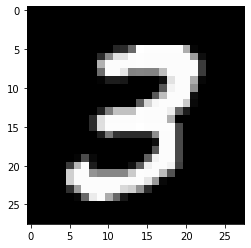

In [63]:
x = np.load('one_image.npy')
plt.imshow(x.reshape((28, 28)), cmap='gray')

In [64]:
# Generate 1000 random rotations of the same image
X   = np.zeros((1000,28*28))
tmp = x.reshape((28, 28))
for i in range(1000):
    X[i,:] = rotate(tmp, np.random.uniform(0,360)).reshape((1,-1))
X   = X/255

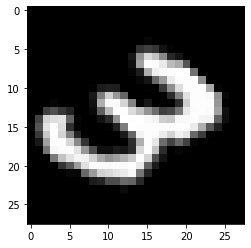

In [65]:
plt.imshow(X[1,:].reshape((28, 28)), cmap='gray')

In [66]:
def Gkernel(X,e):
    """
    return the Gaussian kernel
    """
    distances = sp.spatial.distance_matrix(X, X)
    K = np.exp(-np.power(distances, 2)/e)
    
    return K


def Diffusion(X, d, alpha, e, t):
    """
    apply diffusion map to do dimensionality reduction
    
    return d-dimensional embedding of X
    """
    L = Gkernel(X,e)  # L
    m = L.shape[0]
    
    if alpha != 0:
        diaglist = np.zeros(m)
        for i in range(m):
            diaglist[i] = 1/(np.sum(L[i,:])**alpha)
        Dinv = np.diag(diaglist)
        L = np.dot(np.dot(Dinv,L),Dinv)  # find L^(alpha)=D^-alpha*L*D^-alpha
        for i in range(m):
            diaglist[i] = 1/(np.sum(L[i,:]))
        Dinva = np.diag(diaglist)
        M = np.dot(Dinva, L)  # find M=(D^(alpha))^-1*L^(alpha)
    else:
        return 'use positive value for alpha!'
    
    
    evalue, evector = np.linalg.eig(M)  # find evalues of evector of M
    Index = np.argsort(evalue)
    evalue = evalue[Index[::-1]]
    Vscalar = evalue[1:d+1]**t
    evector = evector[:,Index[::-1]]
    V = evector[:, 1:d+1]
    
    return V*Vscalar.T

In [67]:
d = 2
alpha = 4
e = 1
t = 5

Y = Diffusion(X, d, alpha, e, t)  # call diffusionMap

/Users/lijinnan/.conda/envs/pycourse/lib/python3.8/site-packages/numpy/core/_asarray.py:171: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


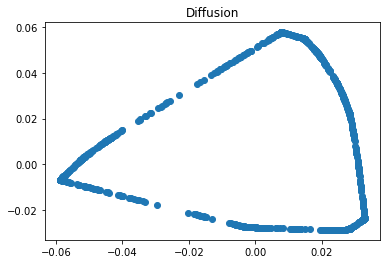

In [68]:
plt.scatter(Y[:,0], Y[:,1])
plt.title('Diffusion')
plt.show()